# LAB 5. Hypothesis testing. Green taxi case

Test varios hypothesis about ridership volume and trip characteristics for green taxi trips in 2018-2020. 

Does the ridership decline over time? Does it depend on the day of the week and time of the day? Does the distribution of the trip parameters (distance, time, speed) depend on the day of the week and borough?

In [1]:
#import the modules
import pandas as pd
import geopandas as gpd
import urllib.request
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#create the folders
if not os.path.exists('Data'):
    os.mkdir('Data')
if not os.path.exists('Data/TLC'):
    os.mkdir('Data/TLC')

In [3]:
# Download green taxi data if not downloaded yet; might take a couple of minutes
for year in [2018, 2019, 2020]:
    for month in range(1, 13):
        if year == 2020 and month > 6:
            pass
        else:
            parquet_file = f'green_tripdata_{year}-{str(month).zfill(2)}.parquet'
            csv_file = f'green_tripdata_{year}-{str(month).zfill(2)}.csv'
            if not os.path.exists(f'Data/TLC/{csv_file}'):
                url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/{parquet_file}'
                parquet_path = f'Data/TLC/{parquet_file}'
                csv_path = f'Data/TLC/{csv_file}'
                
                # Download the parquet file
                urllib.request.urlretrieve(url, parquet_path)
                
                # Convert parquet to csv
                df = pd.read_parquet(parquet_path)
                df.to_csv(csv_path, index=False)
                
                # Optionally, remove the parquet file
                os.remove(parquet_path)

print('done')

done


In [4]:
#concatenate all the files into a single dataframe - takes up to a minute
files = os.listdir('./Data/TLC/')
dfList = []

for index,filename in enumerate(files):
    if '.csv' in filename:
        if index == 0:
            df = pd.read_csv('./Data/TLC/'+filename, index_col=None)
        else:
            df = pd.read_csv('./Data/TLC/'+filename, index_col=None, header=0)
        dfList.append(df)
dfTaxi = pd.concat(dfList, axis=0, ignore_index=True)

In [5]:
dfTaxi.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [6]:
#take care of the timestamp types
dfTaxi['lpep_pickup_datetime'] = pd.to_datetime(dfTaxi['lpep_pickup_datetime'])
dfTaxi['lpep_dropoff_datetime'] = pd.to_datetime(dfTaxi['lpep_dropoff_datetime'])

In [7]:
#extract date, year, day of the week and hour (takes some time around half a minute)
dfTaxi['Date'] = dfTaxi['lpep_pickup_datetime'].dt.date
dfTaxi['Month'] = dfTaxi['lpep_pickup_datetime'].dt.month
dfTaxi['Year'] = dfTaxi['lpep_pickup_datetime'].dt.year
dfTaxi['DOW'] = dfTaxi['lpep_pickup_datetime'].dt.dayofweek
dfTaxi['Hour'] = dfTaxi['lpep_pickup_datetime'].dt.hour
dfTaxi['Minute'] = dfTaxi['lpep_pickup_datetime'].dt.minute
dfTaxi = dfTaxi.loc[dfTaxi['Year'].isin([2018,2019,2020])]

In [8]:
#calculate trip duration in minutes
dfTaxi['trip_duration'] = (dfTaxi['lpep_dropoff_datetime'] - dfTaxi['lpep_pickup_datetime'])
dfTaxi['trip_duration'] = dfTaxi['trip_duration'].dt.total_seconds() / 60

In [9]:
dfTaxi['speed'] = dfTaxi['trip_distance'] / (dfTaxi['trip_duration'] / 60) #avg trip speed in miles per hoiur

In [10]:
len(dfTaxi) #original number of records

16426014

In [11]:
dfTaxi['Date']=pd.to_datetime(dfTaxi["Date"])

In [12]:
#sanity filtering
dfTaxi = dfTaxi[(dfTaxi['Date']<=pd.to_datetime('6/30/2020')) & (dfTaxi.trip_distance < 100)
           & (dfTaxi.speed <= 80) & (dfTaxi.speed >= 1) & (dfTaxi.trip_duration <= 100) & (dfTaxi.trip_duration >= 1)]
len(dfTaxi) #remaining records

15881382

In [13]:
#daily total trip counts and cumulative duration and distance traveled
dfTaxiDaily = dfTaxi.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxiDaily = dfTaxiDaily.sort_values(by='Date')

In [14]:
dfTaxiDaily['speed'] = dfTaxiDaily['trip_distance'] / dfTaxiDaily['trip_duration'] * 60

In [15]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,1,0,2018-01-01,22384,263853.966667,67911.34,15.442938
5,2018,1,1,2018-01-02,22583,274362.416667,59493.64,13.010595
10,2018,1,2,2018-01-03,25673,341670.100000,69394.22,12.186180
15,2018,1,3,2018-01-04,6297,80896.516667,16403.10,12.165987
19,2018,1,4,2018-01-05,26727,341303.233333,64290.25,11.302017


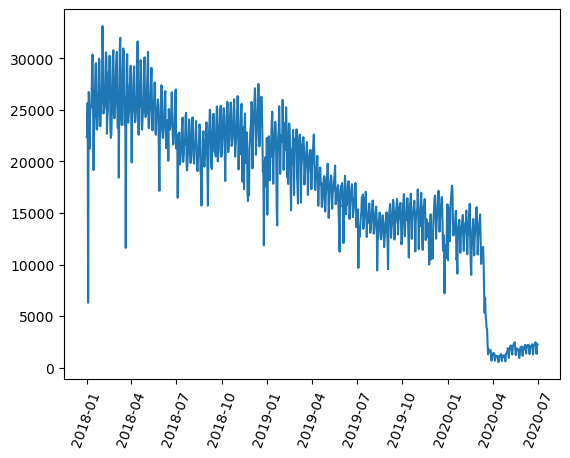

In [16]:
#ridership timeline - daily trip counts; seem to decline and particularly during the pandemics lockdown
plt.plot(dfTaxiDaily['Date'], dfTaxiDaily['trip_count'])
plt.xticks(rotation=70);
plt.show()

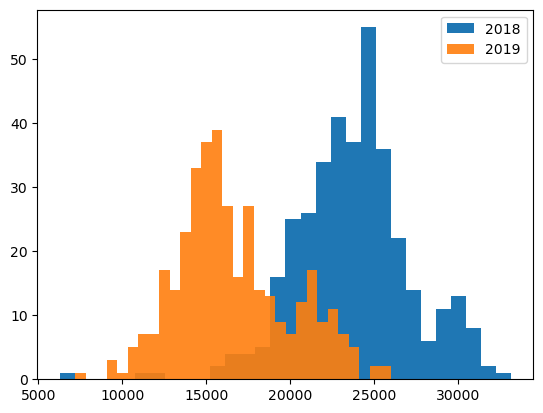

In [17]:
#histograms of daily counts in 2019 and 2018 - distributions look different
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'].values,bins=30,label='2018')
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'].values,bins=30,alpha=0.9,label='2019')
#plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.5,label='2020')
plt.legend()

In [18]:
## t-test between the 2019 and 2018 distributions
stats.ttest_ind(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

TtestResult(statistic=28.657087941915254, pvalue=1.666456504219968e-121, df=728.0)

In [19]:
## K-S test
stats.ks_2samp(dfTaxiDaily.loc[dfTaxiDaily['Year']==2018]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'])

KstestResult(statistic=0.7287671232876712, pvalue=3.569826213988359e-94, statistic_location=18906, statistic_sign=-1)

So the hypothesis that 2018 and 2019 daily trip counts follow the same distributions can be rejected beyond any reasonable doubt

In [20]:
#For further analysis select the year 2019
dfTaxiDaily2019 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2019] #daily aggregates
dfTaxi2019 = dfTaxi.loc[dfTaxi['Year']==2019] #individual trips
(dfTaxiDaily2019['trip_count'].sum(),len(dfTaxi2019)) #total trip counts in either dataset

(6050642, 6050642)

## Example 1. Test if weekend ridership is different from weekday

In [21]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# t-test
stats.ttest_ind(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<4]['trip_count'])

TtestResult(statistic=-2.451880479058623, pvalue=0.014760749788942986, df=311.0)

In [22]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<4
# KS-test
stats.ks_2samp(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<4]['trip_count'])

KstestResult(statistic=0.19773647405226352, pvalue=0.0076234894582322054, statistic_location=13746, statistic_sign=1)

Reject the hypothesis that weekends and weekdays follow the same ridership distribution at 95\% significance level

## Example 2. Test if trip speed, duration or distance follow log-normal distributions

<Axes: >

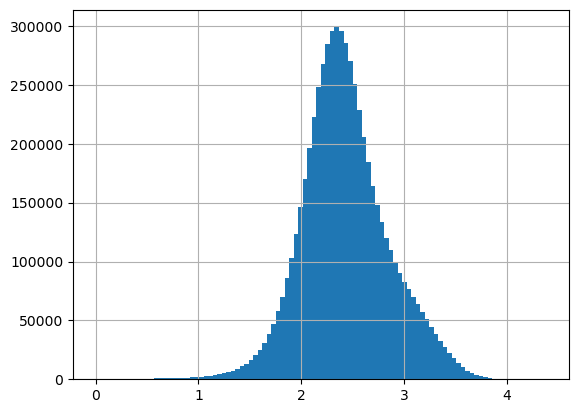

In [23]:
#analyze the overall speed distribution (plot on log-scale)
np.log(dfTaxi2019['speed']).hist(bins=100)

<Axes: >

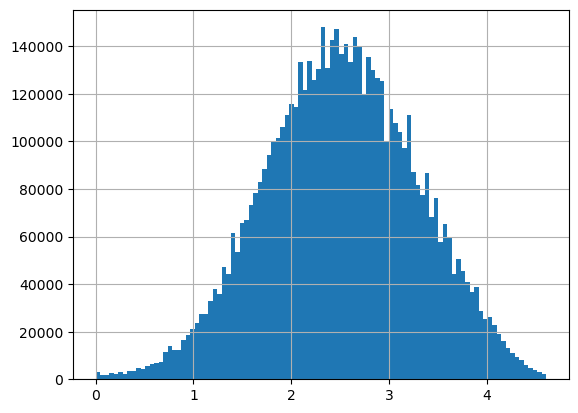

In [24]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_duration']).hist(bins=100)

<Axes: >

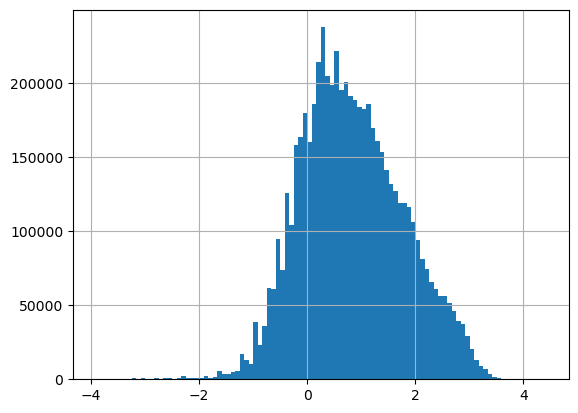

In [25]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_distance']).hist(bins=100)

In [26]:
def is_normal(x): #check if the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [27]:
# is log-speed normally distributed?
is_normal(np.log(dfTaxi2019['speed']))

KstestResult(statistic=0.04112421439405889, pvalue=0.0, statistic_location=2.553899521274952, statistic_sign=1)

In [28]:
# is log-duration normally distributed?
is_normal(np.log(dfTaxi2019['trip_duration']))

KstestResult(statistic=0.009910381706450755, pvalue=0.0, statistic_location=3.2188758248682006, statistic_sign=-1)

In [29]:
# is log-distance normally distributed?
is_normal(np.log(dfTaxi2019['trip_distance']))

KstestResult(statistic=0.038051991909565375, pvalue=0.0, statistic_location=0.5306282510621704, statistic_sign=1)

In [30]:
#so none of those quantities have log-normal distribution (rejecting with 99.9999...% confidence)

In [31]:
#what about daily average trip_count, duration, distance, speed?

In [32]:
is_normal(dfTaxiDaily2019['trip_count']) #does not look normal

KstestResult(statistic=0.08978473661157738, pvalue=0.0052026892522868615, statistic_location=15924, statistic_sign=1)

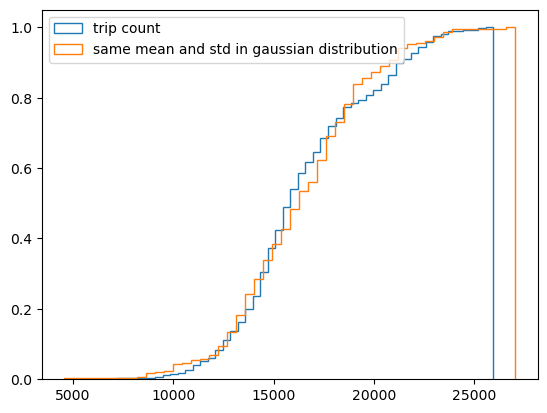

In [33]:
#visualize empiric CDF's for trip-counts
plt.hist(dfTaxiDaily2019['trip_count'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip count')
plt.hist(np.random.normal(dfTaxiDaily2019['trip_count'].mean(), dfTaxiDaily2019['trip_count'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [34]:
is_normal(np.log(dfTaxiDaily2019['trip_count'])) #but might be log-normal

KstestResult(statistic=0.05176889942437113, pvalue=0.2724527644257917, statistic_location=9.929691218032765, statistic_sign=-1)

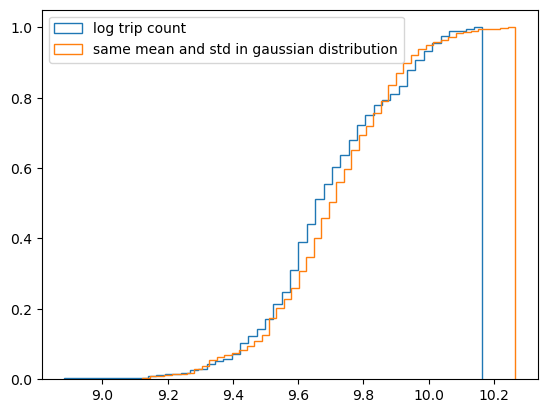

In [35]:
#visualize empiric CDF's for log trip-counts
plt.hist(np.log(dfTaxiDaily2019['trip_count'].values), 50, density=True, 
         histtype='step',cumulative=True,label='log trip count')
plt.hist(np.random.normal(np.log(dfTaxiDaily2019['trip_count']).mean(), np.log(dfTaxiDaily2019['trip_count']).std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')

In [36]:
is_normal(dfTaxiDaily2019['trip_duration']) #could be normal

KstestResult(statistic=0.08629102051381943, pvalue=0.008181442632356909, statistic_location=294726.48333333334, statistic_sign=1)

<Axes: >

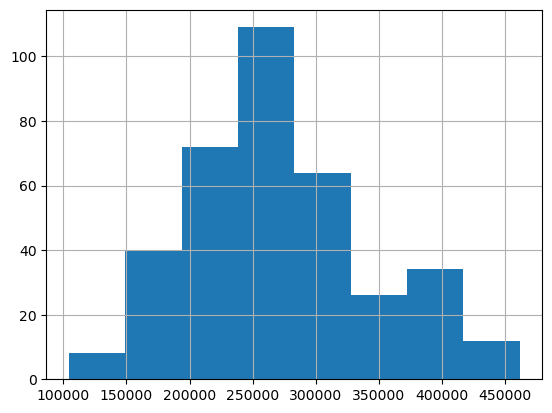

In [37]:
dfTaxiDaily2019['trip_duration'].hist(bins=8)

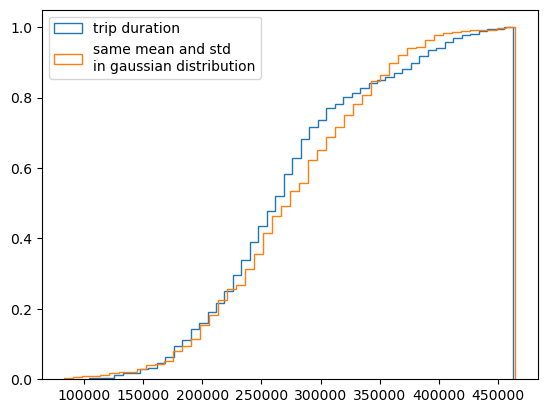

In [38]:
_ = plt.hist(dfTaxiDaily2019['trip_duration'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip duration')
_ = plt.hist(np.random.normal(dfTaxiDaily2019['trip_duration'].mean(), 
                              dfTaxiDaily2019['trip_duration'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std \nin gaussian distribution')
plt.legend(loc='upper left')

In [39]:
is_normal(dfTaxiDaily2019['trip_distance']) #does not look normal

KstestResult(statistic=0.17163545001482683, pvalue=7.163182264727883e-10, statistic_location=61169.01, statistic_sign=1)

In [40]:
is_normal(np.log(dfTaxiDaily2019['trip_distance'])) #but might be log-normal

KstestResult(statistic=0.12271548280911115, pvalue=3.005447778584722e-05, statistic_location=11.021395967701523, statistic_sign=1)

In [41]:
is_normal(dfTaxiDaily2019['speed']) #might be normal

KstestResult(statistic=0.07628804961462937, pvalue=0.027073301479906164, statistic_location=12.833311327932032, statistic_sign=1)

In [42]:
is_normal(np.log(dfTaxiDaily2019['speed'])) #log-normal even more likely

KstestResult(statistic=0.06791252706897999, pvalue=0.06584459147143584, statistic_location=2.552044237917564, statistic_sign=1)

## Homework assignment

## Task 1. Travel speed - hours of the day
Traffic and travel speed might vary throughout the day. Select the trips happening on Oct, 1, 2019. a) Compute average travel speed per each hour of the day and visuale as a bar plot. Compare the speed distributions for: b) trip samples within an hour of 9am (Hour=9) and an hour of 10am, c) morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18)). Can you reject the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95\% significance level?

In [43]:
# Select the trips happening on Oct, 1, 2019
dfTaxi_day=dfTaxi[(dfTaxi['Date']==pd.to_datetime('10/1/2019'))]
dfTaxi_day.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,Minute,trip_duration,speed
13760139,2,2019-10-01 00:02:03,2019-10-01 00:03:34,N,1.0,166,166,1.0,0.36,3.5,...,1.0,0.0,2019-10-01,10,2019,1,0,2,1.516667,14.241758
13760341,2,2019-10-01 00:02:07,2019-10-01 00:12:34,N,1.0,130,205,1.0,2.85,11.0,...,1.0,0.0,2019-10-01,10,2019,1,0,2,10.450000,16.363636
13760379,2,2019-10-01 00:00:05,2019-10-01 00:05:50,N,1.0,256,37,1.0,1.21,6.5,...,1.0,0.0,2019-10-01,10,2019,1,0,0,5.750000,12.626087
13819523,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.0,...,1.0,0.0,2019-10-01,10,2019,1,0,26,13.933333,25.320574
13819524,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.0,...,1.0,0.0,2019-10-01,10,2019,1,0,18,4.450000,10.786517


In [44]:
dfTaxi_hour = dfTaxi_day.groupby(['Year','Month','DOW','Date','Hour']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxi_hour = dfTaxi_hour.sort_values(by=['Hour'])
dfTaxi_hour.head()

,Year,Month,DOW,Date,Hour,trip_count,trip_duration,trip_distance
0,2019,10,1,2019-10-01,0,214,2334.350000,668.85
1,2019,10,1,2019-10-01,1,127,1381.233333,385.41
2,2019,10,1,2019-10-01,2,72,782.450000,215.77
3,2019,10,1,2019-10-01,3,79,923.000000,318.19
4,2019,10,1,2019-10-01,4,86,1285.066667,507.86


In [45]:
# Compute average travel speed per each hour of the day
dfTaxi_hour['speed'] = dfTaxi_hour['trip_distance'] / (dfTaxi_hour['trip_duration'] / 60)
dfTaxi_hour.head()

,Year,Month,DOW,Date,Hour,trip_count,trip_duration,trip_distance,speed
0,2019,10,1,2019-10-01,0,214,2334.350000,668.85,17.191509
1,2019,10,1,2019-10-01,1,127,1381.233333,385.41,16.741994
2,2019,10,1,2019-10-01,2,72,782.450000,215.77,16.545722
3,2019,10,1,2019-10-01,3,79,923.000000,318.19,20.684074
4,2019,10,1,2019-10-01,4,86,1285.066667,507.86,23.712077


<BarContainer object of 24 artists>

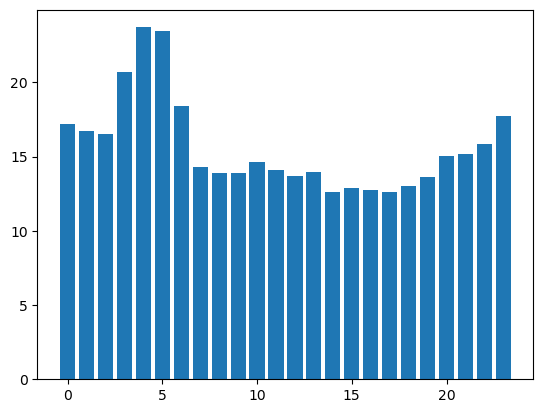

In [46]:
#visuale as a bar plot
plt.bar(dfTaxi_hour['Hour'], dfTaxi_hour['speed'])

In [47]:
# trip samples within an hour of 9am (Hour=9) and an hour of 10am
# the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95% significance level

In [48]:
dfTaxi_day.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,Minute,trip_duration,speed
13760139,2,2019-10-01 00:02:03,2019-10-01 00:03:34,N,1.0,166,166,1.0,0.36,3.5,...,1.0,0.0,2019-10-01,10,2019,1,0,2,1.516667,14.241758
13760341,2,2019-10-01 00:02:07,2019-10-01 00:12:34,N,1.0,130,205,1.0,2.85,11.0,...,1.0,0.0,2019-10-01,10,2019,1,0,2,10.450000,16.363636
13760379,2,2019-10-01 00:00:05,2019-10-01 00:05:50,N,1.0,256,37,1.0,1.21,6.5,...,1.0,0.0,2019-10-01,10,2019,1,0,0,5.750000,12.626087
13819523,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.0,...,1.0,0.0,2019-10-01,10,2019,1,0,26,13.933333,25.320574
13819524,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.0,...,1.0,0.0,2019-10-01,10,2019,1,0,18,4.450000,10.786517


In [49]:
dfTaxi_day.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,Minute,trip_duration,speed
13760139,2,2019-10-01 00:02:03,2019-10-01 00:03:34,N,1.0,166,166,1.0,0.36,3.5,...,1.0,0.0,2019-10-01,10,2019,1,0,2,1.516667,14.241758
13760341,2,2019-10-01 00:02:07,2019-10-01 00:12:34,N,1.0,130,205,1.0,2.85,11.0,...,1.0,0.0,2019-10-01,10,2019,1,0,2,10.450000,16.363636
13760379,2,2019-10-01 00:00:05,2019-10-01 00:05:50,N,1.0,256,37,1.0,1.21,6.5,...,1.0,0.0,2019-10-01,10,2019,1,0,0,5.750000,12.626087
13819523,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.0,...,1.0,0.0,2019-10-01,10,2019,1,0,26,13.933333,25.320574
13819524,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.0,...,1.0,0.0,2019-10-01,10,2019,1,0,18,4.450000,10.786517


In [50]:
Nine=dfTaxi_day[(dfTaxi_day['Hour'] == 9)]
Ten=dfTaxi_day[(dfTaxi_day['Hour'] == 10)]
Nine.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,Minute,trip_duration,speed
13820885,2,2019-10-01 09:15:09,2019-10-01 09:38:55,N,1.0,244,68,5.0,8.65,26.5,...,1.0,2.75,2019-10-01,10,2019,1,9,15,23.766667,21.837307
13820907,2,2019-10-01 09:03:15,2019-10-01 09:07:27,N,1.0,41,41,1.0,0.79,5.0,...,1.0,0.00,2019-10-01,10,2019,1,9,3,4.200000,11.285714
13820913,2,2019-10-01 09:01:15,2019-10-01 09:16:41,N,1.0,74,244,5.0,3.91,15.0,...,1.0,0.00,2019-10-01,10,2019,1,9,1,15.433333,15.200864
13820945,2,2019-10-01 09:06:33,2019-10-01 09:09:19,N,1.0,52,33,1.0,0.58,4.0,...,1.0,0.00,2019-10-01,10,2019,1,9,6,2.766667,12.578313
13821001,2,2019-10-01 09:14:58,2019-10-01 09:29:28,N,1.0,159,74,1.0,2.39,11.5,...,1.0,0.00,2019-10-01,10,2019,1,9,14,14.500000,9.889655


In [51]:
#t-test between the 9AM and 10AM mean
stats.ttest_ind(Nine['speed'],Ten['speed'])

TtestResult(statistic=-1.173277394807621, pvalue=0.2408567402829922, df=1623.0)

In [52]:
stats.ks_2samp(Nine['speed'], Ten['speed'])

KstestResult(statistic=0.04866545344252351, pvalue=0.2793212653142789, statistic_location=8.666666666666668, statistic_sign=1)

In [53]:
# We can not reject the hypothesis that the samples of 9AM and 10AM have the same mean and distribution at a 95% significance level.

In [54]:
# trip samples within morning rush hour (two hours of 8 and 9am) and evening rush hour (two hours of 5pm(17) and 6pm(18)).
# the hypothesis that the compared speed samples have the same mean(use t-test) and distribution (use ks-test) at a 95% significance level

In [55]:
morning_rush_hour = dfTaxi_day[(dfTaxi_day['Hour'] >= 8) & (dfTaxi_day['Hour'] <= 9)]
evening_rush_hour = dfTaxi_day[(dfTaxi_day['Hour'] >= 17) & (dfTaxi_day['Hour'] <= 18)]

In [56]:
morning_rush_hour.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,Minute,trip_duration,speed
13820007,2,2019-10-01 08:37:38,2019-10-01 08:38:38,N,1.0,42,42,1.0,0.26,3.0,...,1.0,0.00,2019-10-01,10,2019,1,8,37,1.000000,15.600000
13820008,2,2019-10-01 08:40:57,2019-10-01 09:14:54,N,1.0,41,234,1.0,5.27,23.5,...,1.0,2.75,2019-10-01,10,2019,1,8,40,33.950000,9.313697
13820367,2,2019-10-01 08:00:06,2019-10-01 08:34:41,N,1.0,66,66,5.0,9.83,33.0,...,1.0,2.75,2019-10-01,10,2019,1,8,0,34.583333,17.054458
13820407,2,2019-10-01 08:01:21,2019-10-01 08:06:11,N,1.0,42,41,1.0,0.84,5.5,...,1.0,0.00,2019-10-01,10,2019,1,8,1,4.833333,10.427586
13820429,2,2019-10-01 08:01:45,2019-10-01 08:13:53,N,1.0,7,145,1.0,2.69,11.0,...,1.0,0.00,2019-10-01,10,2019,1,8,1,12.133333,13.302198


In [57]:
stats.ttest_ind(morning_rush_hour['speed'],evening_rush_hour['speed'])

TtestResult(statistic=5.316218844376518, pvalue=1.1253493376433583e-07, df=3522.0)

In [58]:
stats.ks_2samp(morning_rush_hour['speed'], evening_rush_hour['speed'])

KstestResult(statistic=0.06860517517057287, pvalue=0.0005164093592967348, statistic_location=10.858695652173914, statistic_sign=-1)

 We can reject the hypothesis that the samples of morning rush hour and evening rush hour have the same mean and distribution at a 95% significance level.

## Task 2. Travel speed - days of the week
Traffic and travel speed also vary during different weekdays. a) Compute average travel speed per each of the 7 days of the week (among all the individual trips happening on Mondays, Tuesdays, Wednesdays etc); visualize those as a bar plot. Then compute average travel speed per each day of the week and perform a pairwise comparison between the distributions of the daily speed averages within different days of the week (i.e. distribution of all Mondays vs all Tuesdays etc). Compute p-value of the ks-test for each pair of the different weekdays and compare with 5\%. As a results we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5\%), "keep" (if p-value above 5\%) and "-" on the diagonal.

In [59]:
# Compute average travel speed per each of the 7 days of the week 

In [60]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,1,0,2018-01-01,22384,263853.966667,67911.34,15.442938
5,2018,1,1,2018-01-02,22583,274362.416667,59493.64,13.010595
10,2018,1,2,2018-01-03,25673,341670.100000,69394.22,12.186180
15,2018,1,3,2018-01-04,6297,80896.516667,16403.10,12.165987
19,2018,1,4,2018-01-05,26727,341303.233333,64290.25,11.302017


In [61]:
dfTaxiDaily_DOW = dfTaxiDaily.groupby(['DOW']).\
            agg({'trip_duration':'sum','trip_distance':'sum'})

In [62]:
dfTaxiDaily_DOW['average travel speed']=dfTaxiDaily_DOW['trip_distance']/dfTaxiDaily_DOW['trip_duration']*60
dfTaxiDaily_DOW

,trip_duration,trip_distance,average travel speed
DOW,,,
0,3.271465e+07,7346729.35,13.474200
1,3.592646e+07,7768934.75,12.974730
2,3.744882e+07,8044210.21,12.888325
3,3.947172e+07,8263397.93,12.560989
4,4.090780e+07,8553861.26,12.546060
5,3.488742e+07,8104591.86,13.938421
6,2.802968e+07,6997613.31,14.979006


In [63]:
week_of_day = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dfTaxiDaily_DOW['week_of_day'] = week_of_day
dfTaxiDaily_DOW

,trip_duration,trip_distance,average travel speed,week_of_day
DOW,,,,
0,3.271465e+07,7346729.35,13.474200,Monday
1,3.592646e+07,7768934.75,12.974730,Tuesday
2,3.744882e+07,8044210.21,12.888325,Wednesday
3,3.947172e+07,8263397.93,12.560989,Thursday
4,4.090780e+07,8553861.26,12.546060,Friday
5,3.488742e+07,8104591.86,13.938421,Saturday
6,2.802968e+07,6997613.31,14.979006,Sunday


<BarContainer object of 7 artists>

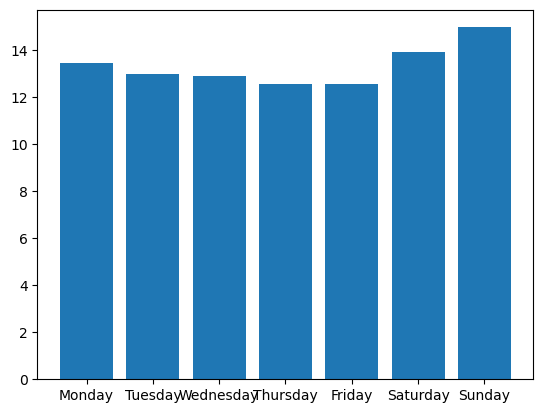

In [64]:
plt.bar(dfTaxiDaily_DOW['week_of_day'] , dfTaxiDaily_DOW['average travel speed'] )

In [65]:
# Compute average travel speed per each day of the week

In [66]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,1,0,2018-01-01,22384,263853.966667,67911.34,15.442938
5,2018,1,1,2018-01-02,22583,274362.416667,59493.64,13.010595
10,2018,1,2,2018-01-03,25673,341670.100000,69394.22,12.186180
15,2018,1,3,2018-01-04,6297,80896.516667,16403.10,12.165987
19,2018,1,4,2018-01-05,26727,341303.233333,64290.25,11.302017


In [67]:
dfTaxiDaily_DOW_1 = dfTaxiDaily.groupby(['DOW','Date']).\
            agg({'trip_count':'count','trip_duration':'sum','trip_distance':'sum','speed':'first'})
dfTaxiDaily_DOW_1
dfTaxiDaily_DOW_2=dfTaxiDaily_DOW_1.reset_index()
dfTaxiDaily_DOW_2

,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,0,2018-01-01,1,263853.966667,67911.34,15.442938
1,0,2018-01-08,1,351788.700000,65498.37,11.171201
2,0,2018-01-15,1,222311.300000,51803.45,13.981327
3,0,2018-01-22,1,301740.350000,64706.69,12.866696
4,0,2018-01-29,1,303618.750000,64758.74,12.797380
...,...,...,...,...,...,...
907,6,2020-05-31,1,16778.016667,5766.89,20.623022
908,6,2020-06-07,1,22792.883333,8012.34,21.091689
909,6,2020-06-14,1,20843.900000,6747.18,19.422028
910,6,2020-06-21,1,20040.766667,6622.12,19.825948


In [68]:
Monday=dfTaxiDaily_DOW_2[(dfTaxiDaily_DOW_2['DOW'] == 0)]
Tuesday=dfTaxiDaily_DOW_2[(dfTaxiDaily_DOW_2['DOW'] == 1)]
Wendesday=dfTaxiDaily_DOW_2[(dfTaxiDaily_DOW_2['DOW'] == 2)]
Thursday=dfTaxiDaily_DOW_2[(dfTaxiDaily_DOW_2['DOW'] == 3)]
Friday=dfTaxiDaily_DOW_2[(dfTaxiDaily_DOW_2['DOW'] == 4)]
Saturday=dfTaxiDaily_DOW_2[(dfTaxiDaily_DOW_2['DOW'] == 5)]
Sunday=dfTaxiDaily_DOW_2[(dfTaxiDaily_DOW_2['DOW'] == 6)]

In [69]:
ks_statistic, p_value_MON_TUE = stats.ks_2samp(Monday['speed'], Tuesday['speed'])
ks_statistic, p_value_MON_WEN = stats.ks_2samp(Monday['speed'], Wendesday['speed'])
ks_statistic, p_value_MON_THU = stats.ks_2samp(Monday['speed'], Thursday['speed'])
ks_statistic, p_value_MON_FRI = stats.ks_2samp(Monday['speed'], Friday['speed'])
ks_statistic, p_value_MON_SAT = stats.ks_2samp(Monday['speed'], Saturday['speed'])
ks_statistic, p_value_MON_SUN = stats.ks_2samp(Monday['speed'], Sunday['speed'])
ks_statistic, p_value_TUE_WEN = stats.ks_2samp(Tuesday['speed'], Wendesday['speed'])
ks_statistic, p_value_TUE_THU = stats.ks_2samp(Tuesday['speed'], Thursday['speed'])
ks_statistic, p_value_TUE_FRI = stats.ks_2samp(Tuesday['speed'], Friday['speed'])
ks_statistic, p_value_TUE_SAT = stats.ks_2samp(Tuesday['speed'], Saturday['speed'])
ks_statistic, p_value_TUE_SUN = stats.ks_2samp(Tuesday['speed'], Sunday['speed'])
ks_statistic, p_value_WEN_THU = stats.ks_2samp(Wendesday['speed'], Thursday['speed'])
ks_statistic, p_value_WEN_FRI = stats.ks_2samp(Wendesday['speed'], Friday['speed'])
ks_statistic, p_value_WEN_SAT = stats.ks_2samp(Wendesday['speed'], Saturday['speed'])
ks_statistic, p_value_WEN_SUN = stats.ks_2samp(Wendesday['speed'], Sunday['speed'])
ks_statistic, p_value_THU_FRI = stats.ks_2samp(Thursday['speed'], Friday['speed'])
ks_statistic, p_value_THU_SAT = stats.ks_2samp(Thursday['speed'], Saturday['speed'])
ks_statistic, p_value_THU_SUN = stats.ks_2samp(Thursday['speed'], Sunday['speed'])
ks_statistic, p_value_FRI_SAT = stats.ks_2samp(Friday['speed'], Sunday['speed'])
ks_statistic, p_value_FRI_SUN = stats.ks_2samp(Friday['speed'], Saturday['speed'])
ks_statistic, p_value_SAT_SUN = stats.ks_2samp(Saturday['speed'], Sunday['speed'])
p_value_MON_MON=p_value_TUE_TUE=p_value_WEN_WEN=p_value_THU_THU=p_value_FRI_FRI=p_value_SAT_SAT=p_value_SUN_SUN='-'
p_value_TUE_MON=p_value_MON_TUE
p_value_WEN_MON=p_value_MON_WEN
p_value_THU_MON=p_value_MON_THU
p_value_FRI_MON=p_value_MON_FRI
p_value_SAT_MON=p_value_MON_SAT
p_value_SUN_MON=p_value_MON_SUN
p_value_WEN_TUE=p_value_TUE_WEN
p_value_THU_TUE=p_value_TUE_THU
p_value_FRI_TUE=p_value_TUE_FRI
p_value_SAT_TUE=p_value_TUE_SAT
p_value_SUN_TUE=p_value_TUE_SUN
p_value_THU_WEN=p_value_WEN_THU
p_value_FRI_WEN=p_value_WEN_FRI
p_value_SAT_WEN=p_value_WEN_SAT
p_value_SUN_WEN=p_value_WEN_SUN
p_value_FRI_THU=p_value_THU_FRI
p_value_SAT_THU=p_value_THU_SAT
p_value_SUN_THU=p_value_THU_SUN
p_value_SAT_FRI=p_value_FRI_SAT
p_value_SUN_FRI=p_value_FRI_SUN
p_value_SUN_SAT=p_value_SAT_SUN

In [70]:
# Compute p-value of the ks-test for each pair of the different weekdays and compare with 5\%.matrix_data = np.array(data).reshape(7, 7)
# As a results we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5\%), "keep" (if p-value above 5\%) and "-" on the diagonal.

In [71]:
data = [p_value_MON_MON,p_value_MON_TUE,p_value_MON_WEN,p_value_MON_THU,p_value_MON_FRI,p_value_MON_SAT,p_value_MON_SUN,p_value_TUE_MON,p_value_TUE_TUE,p_value_TUE_WEN,p_value_TUE_THU,p_value_TUE_FRI,p_value_TUE_SAT,p_value_TUE_SUN,p_value_WEN_MON,p_value_WEN_TUE,p_value_WEN_WEN,p_value_WEN_THU,p_value_WEN_FRI,p_value_WEN_SAT,p_value_WEN_SUN,p_value_THU_MON,p_value_THU_TUE,p_value_THU_WEN,p_value_THU_THU,p_value_THU_FRI,p_value_THU_SAT,p_value_THU_SUN,p_value_FRI_MON,p_value_FRI_TUE,p_value_FRI_WEN,p_value_FRI_THU,p_value_FRI_FRI,p_value_FRI_SAT,p_value_FRI_SUN,p_value_SAT_MON,p_value_SAT_TUE,p_value_SAT_WEN,p_value_SAT_THU,p_value_SAT_FRI,p_value_SAT_SAT,p_value_SAT_SUN,p_value_SUN_MON,p_value_SUN_TUE,p_value_SUN_WEN,p_value_SUN_THU,p_value_SUN_FRI,p_value_SUN_SAT,p_value_SUN_SUN]

matrix_data = [[None] * 7 for _ in range(7)]

for i in range(7):
    for j in range(7):
        index = i * 7 + j
        if index < 49:
            matrix_data[i][j] = data[index]

dfTaxiDaily_DOW3 = pd.DataFrame(matrix_data, columns=["Monday", "Tuesday", "Wendesday", "Thursday", "Friday", "Saturday", "Sunday"], index=["Monday", "Tuesday", "Wendesday", "Thursday", "Friday", "Saturday", "Sunday"])

dfTaxiDaily_DOW3

,Monday,Tuesday,Wendesday,Thursday,Friday,Saturday,Sunday
Monday,-,0.000767,0.000011,0.0,0.0,0.000003,0.0
Tuesday,0.000767,-,0.549577,0.000067,0.000199,0.0,0.0
Wendesday,0.000011,0.549577,-,0.001901,0.004694,0.0,0.0
Thursday,0.0,0.000067,0.001901,-,0.999179,0.0,0.0
Friday,0.0,0.000199,0.004694,0.999179,-,0.0,0.0
Saturday,0.000003,0.0,0.0,0.0,0.0,-,0.0
Sunday,0.0,0.0,0.0,0.0,0.0,0.0,-


In [72]:
def replace_value(value):
    if value == '-':
        return '-'
    else:
        if value < 0.05:
            return 'reject'
        else:
            return 'keep'

dfTaxiDaily_DOW3 = dfTaxiDaily_DOW3.applymap(replace_value)


dfTaxiDaily_DOW3

,Monday,Tuesday,Wendesday,Thursday,Friday,Saturday,Sunday
Monday,-,reject,reject,reject,reject,reject,reject
Tuesday,reject,-,keep,reject,reject,reject,reject
Wendesday,reject,keep,-,reject,reject,reject,reject
Thursday,reject,reject,reject,-,keep,reject,reject
Friday,reject,reject,reject,keep,-,reject,reject
Saturday,reject,reject,reject,reject,reject,-,reject
Sunday,reject,reject,reject,reject,reject,reject,-


## Task 3. Trip speeds per borough.

For the day of Oct, 1, 2019 compute the average trip speed in Brooklyn, Queens and Bronx (by pickup). Then compare the samples of the trip speeds in Brooklyn, Queens and Bronx on that day using t-test and ks-test (pairwise comparison). Fill two 3x3 pandas dataframes (one for t-test, one for ks-test) with p-values for each pair of boroughs. Can we reject the null hypothesis that speed mean/distributions within each pair of boroughs is is similar?

HINT: Download taxizone geojson from 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON' to define borough for each pickup taxi zone.

In [73]:
# download taxizone map
file = 'taxizone.geojson'
url = 'https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON'
urllib.request.urlretrieve(url,'Data/TLC/'+file)

('Data/TLC/taxizone.geojson', <http.client.HTTPMessage at 0x1c98b21d1d0>)

In [74]:
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON')
taxi.head()

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ..."
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."


In [75]:
dfTaxi_day.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,trip_type,congestion_surcharge,Date,Month,Year,DOW,Hour,Minute,trip_duration,speed
13760139,2,2019-10-01 00:02:03,2019-10-01 00:03:34,N,1.0,166,166,1.0,0.36,3.5,...,1.0,0.0,2019-10-01,10,2019,1,0,2,1.516667,14.241758
13760341,2,2019-10-01 00:02:07,2019-10-01 00:12:34,N,1.0,130,205,1.0,2.85,11.0,...,1.0,0.0,2019-10-01,10,2019,1,0,2,10.450000,16.363636
13760379,2,2019-10-01 00:00:05,2019-10-01 00:05:50,N,1.0,256,37,1.0,1.21,6.5,...,1.0,0.0,2019-10-01,10,2019,1,0,0,5.750000,12.626087
13819523,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.0,...,1.0,0.0,2019-10-01,10,2019,1,0,26,13.933333,25.320574
13819524,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.0,...,1.0,0.0,2019-10-01,10,2019,1,0,18,4.450000,10.786517


In [76]:
dfTaxi_day['PULocationID'] = dfTaxi_day['PULocationID'].astype(int)
taxi['location_id'] = taxi['location_id'].astype(int)

In [77]:
taxi = taxi.drop_duplicates(subset=['location_id'])

In [78]:
TaxiViz =dfTaxi_day.merge(taxi, left_on='PULocationID', right_on='location_id', how='left')
TaxiViz.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,Minute,trip_duration,speed,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,2,2019-10-01 00:02:03,2019-10-01 00:03:34,N,1.0,166,166,1.0,0.36,3.5,...,2,1.516667,14.241758,0.000255276270405,166,0.0688237542871,166.0,Morningside Heights,Manhattan,"MULTIPOLYGON (((-73.95708 40.81430, -73.95627 ..."
1,2,2019-10-01 00:02:07,2019-10-01 00:12:34,N,1.0,130,205,1.0,2.85,11.0,...,2,10.450000,16.363636,0.000468322514327,130,0.142028320665,130.0,Jamaica,Queens,"MULTIPOLYGON (((-73.76963 40.71179, -73.77007 ..."
2,2,2019-10-01 00:00:05,2019-10-01 00:05:50,N,1.0,256,37,1.0,1.21,6.5,...,0,5.750000,12.626087,0.000168611097013,256,0.0679149669603,256.0,Williamsburg (South Side),Brooklyn,"MULTIPOLYGON (((-73.95834 40.71331, -73.95681 ..."
3,2,2019-10-01 00:26:02,2019-10-01 00:39:58,N,1.0,112,196,1.0,5.88,18.0,...,26,13.933333,25.320574,0.000462068671429,112,0.107267875765,112.0,Greenpoint,Brooklyn,"MULTIPOLYGON (((-73.95440 40.73911, -73.95428 ..."
4,1,2019-10-01 00:18:11,2019-10-01 00:22:38,N,1.0,43,263,1.0,0.80,5.0,...,18,4.450000,10.786517,0.000379662912054,43,0.0997386183576,43.0,Central Park,Manhattan,"MULTIPOLYGON (((-73.97255 40.76490, -73.97301 ..."


In [79]:
TaxiViz_mean_speed = TaxiViz.groupby(['borough']).\
            agg({'trip_duration':'sum','trip_distance':'sum'})
TaxiViz_mean_speed1=TaxiViz_mean_speed.reset_index()
TaxiViz_mean_speed1['ave_speed']=TaxiViz_mean_speed1['trip_distance']/TaxiViz_mean_speed1['trip_duration']*60
TaxiViz_mean_speed1

,borough,trip_duration,trip_distance,ave_speed
0,Bronx,21668.050000,6101.52,16.895438
1,Brooklyn,68969.366667,15933.62,13.861476
2,Manhattan,67148.050000,14408.71,12.874873
3,Queens,51401.983333,12824.63,14.969808
4,Staten Island,145.616667,59.62,24.565869


In [80]:
Brooklyn=TaxiViz[(TaxiViz['borough'] == 'Brooklyn')]
Queens=TaxiViz[(TaxiViz['borough'] == 'Queens')]
Bronx=TaxiViz[(TaxiViz['borough'] == 'Bronx')]

In [81]:
t_stat, p_value_BN_Q=stats.ttest_ind(Brooklyn['speed'],Queens['speed'])
t_stat, p_value_BN_BX=stats.ttest_ind(Brooklyn['speed'],Bronx['speed'])
t_stat, p_value_Q_BX=stats.ttest_ind(Queens['speed'],Bronx['speed'])
p_value_BN_BN=p_value_BX_BX=p_value_Q_Q=1

In [82]:
stats.ttest_ind(Brooklyn['speed'],Queens['speed'])

TtestResult(statistic=-7.966592279969484, pvalue=1.879581961355796e-15, df=7282.0)

In [83]:
data1 = [[p_value_BN_BN,p_value_BN_Q,p_value_BN_BX],
        [p_value_BN_Q, p_value_Q_Q,p_value_Q_BX],
        [p_value_BN_BX,p_value_Q_BX, p_value_BX_BX]]

In [84]:
float_data = [[float(item) for item in sublist] for sublist in data1]

In [85]:
columns = ["BN", "Q", "BX"]
index = ["BN", "Q", "BX"]
Taxi_t= pd.DataFrame(data1,columns=columns,index=index)
Taxi_t

,BN,Q,BX
BN,1.000000e+00,1.879582e-15,3.834652e-36
Q,1.879582e-15,1.000000e+00,5.891792e-12
BX,3.834652e-36,5.891792e-12,1.000000e+00


In [86]:
def replace_value(value):
    if value == 1:
        return '-'
    else:
        if value < 0.05:
            return 'reject'
        else:
            return 'keep'

Taxi_t = Taxi_t.applymap(replace_value)
Taxi_t

,BN,Q,BX
BN,-,reject,reject
Q,reject,-,reject
BX,reject,reject,-


In [87]:
ks_statistic,p_value_BN_Q_ks = stats.ks_2samp(Brooklyn['speed'],Queens['speed'])
ks_statistic,p_value_BN_BX_ks = stats.ks_2samp(Brooklyn['speed'],Bronx['speed'])
ks_statistic,p_value_Q_BX_ks= stats.ks_2samp(Queens['speed'],Bronx['speed'])
p_value_BN_BN_ks=p_value_BX_BX_ks=p_value_Q_Q_ks=1

In [88]:
data2 = [[p_value_BN_BN_ks, p_value_BN_Q_ks, p_value_BN_BX_ks],
        [p_value_BN_Q_ks, p_value_Q_Q_ks,p_value_Q_BX_ks],
        [p_value_BN_BX_ks,p_value_Q_BX_ks, p_value_BX_BX_ks]]
float_data = [[float(item) for item in sublist] for sublist in data2]
columns = ["BN", "Q", "BX"]
index = ["BN", "Q", "BX"]
Taxi_ks= pd.DataFrame(data2,columns=columns,index=index)
Taxi_ks

,BN,Q,BX
BN,1.000000e+00,2.524630e-20,1.489717e-37
Q,2.524630e-20,1.000000e+00,3.536545e-13
BX,1.489717e-37,3.536545e-13,1.000000e+00


In [89]:
def replace_value(value):
    if value == 1:
        return '-'
    else:
        if value < 0.05:
            return 'reject'
        else:
            return 'keep'

Taxi_ks = Taxi_ks.applymap(replace_value)
Taxi_ks

,BN,Q,BX
BN,-,reject,reject
Q,reject,-,reject
BX,reject,reject,-


# Task 4. Ridership drop during pandemics
No doubt that 2020 saw a large drop in ridership but how can we assess it? Keep in mind that we don't have the full year, the drop just started in March and there is also a general decline in taxi ridership, so we need a way to distinguish pandemics-related drop from the general trend. In order to account for it, normalize 2020 daily ridership data by the same day's 30-days rolling average (15 days before/after to smoothen out the effect of weekly variations within the baseline) in 2019, and compare the daily ratios of ridership after the shelter in place order (Mar 20th till June, 30th, 2020) and before (Jan, 16-Mar, 20th, 2020). Report p-values of ks-test and t-test. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2020 is the same as before? For comparison and to provide a baseline for evaluating results of the hypothesis testing perform the same analysis for the same periods of 2019. Can we reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2019 is the same as before?

In [90]:
#  Compute the rolling average of 2019 and the daily ratios of ridership of 2020

In [91]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
0,2018,1,0,2018-01-01,22384,263853.966667,67911.34,15.442938
5,2018,1,1,2018-01-02,22583,274362.416667,59493.64,13.010595
10,2018,1,2,2018-01-03,25673,341670.100000,69394.22,12.186180
15,2018,1,3,2018-01-04,6297,80896.516667,16403.10,12.165987
19,2018,1,4,2018-01-05,26727,341303.233333,64290.25,11.302017


In [92]:
dfTaxiDaily_2019=dfTaxiDaily[dfTaxiDaily['Year'] == 2019]
dfTaxiDaily_2019.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
369,2019,1,1,2019-01-01,14829,204879.200000,58749.46,17.205102
374,2019,1,2,2019-01-02,19338,313301.916667,78828.02,15.096241
379,2019,1,3,2019-01-03,21205,354237.833333,85034.73,14.402990
384,2019,1,4,2019-01-04,22448,365312.450000,87958.83,14.446619
388,2019,1,5,2019-01-05,20196,281748.833333,71442.58,15.214100


In [93]:
dfTaxiDaily_2019['rolling_average'] = dfTaxiDaily_2019['trip_count'].rolling(window=31, min_periods=1,center=True).mean()

In [94]:
dfTaxiDaily_2019['Date'] = pd.to_datetime(dfTaxiDaily_2019['Date'])
dfTaxiDaily_2019['Year'] = dfTaxiDaily_2019['Date'].dt.year
dfTaxiDaily_2019['MonthDay'] = dfTaxiDaily_2019['Date'].dt.strftime('%m-%d')
dfTaxiDaily_2019.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,rolling_average,MonthDay
369,2019,1,1,2019-01-01,14829,204879.200000,58749.46,17.205102,20787.312500,01-01
374,2019,1,2,2019-01-02,19338,313301.916667,78828.02,15.096241,20966.941176,01-02
379,2019,1,3,2019-01-03,21205,354237.833333,85034.73,14.402990,21092.388889,01-03
384,2019,1,4,2019-01-04,22448,365312.450000,87958.83,14.446619,21065.000000,01-04
388,2019,1,5,2019-01-05,20196,281748.833333,71442.58,15.214100,20788.350000,01-05


In [95]:
dfTaxiDaily_2020=dfTaxiDaily[dfTaxiDaily['Year'] == 2020]
dfTaxiDaily_2020['Date'] = pd.to_datetime(dfTaxiDaily_2020['Date'])
dfTaxiDaily_2020['Year'] = dfTaxiDaily_2020['Date'].dt.year
dfTaxiDaily_2020['MonthDay'] = dfTaxiDaily_2020['Date'].dt.strftime('%m-%d')
dfTaxiDaily_2020.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed,MonthDay
738,2020,1,2,2020-01-01,10410,146795.583333,42825.83,17.504272,01-01
743,2020,1,3,2020-01-02,14440,241500.683333,61940.19,15.388824,01-02
748,2020,1,4,2020-01-03,15463,252003.183333,62165.15,14.801039,01-03
753,2020,1,5,2020-01-04,13797,205190.250000,54313.63,15.881933,01-04
757,2020,1,6,2020-01-05,12255,176122.633333,49472.43,16.853858,01-05


In [96]:
dfTaxiDaily1 = dfTaxiDaily_2020.merge(dfTaxiDaily_2019, on='MonthDay', how='inner')
dfTaxiDaily1.head()

,Year_x,Month_x,DOW_x,Date_x,trip_count_x,trip_duration_x,trip_distance_x,speed_x,MonthDay,Year_y,Month_y,DOW_y,Date_y,trip_count_y,trip_duration_y,trip_distance_y,speed_y,rolling_average
0,2020,1,2,2020-01-01,10410,146795.583333,42825.83,17.504272,01-01,2019,1,1,2019-01-01,14829,204879.200000,58749.46,17.205102,20787.312500
1,2020,1,3,2020-01-02,14440,241500.683333,61940.19,15.388824,01-02,2019,1,2,2019-01-02,19338,313301.916667,78828.02,15.096241,20966.941176
2,2020,1,4,2020-01-03,15463,252003.183333,62165.15,14.801039,01-03,2019,1,3,2019-01-03,21205,354237.833333,85034.73,14.402990,21092.388889
3,2020,1,5,2020-01-04,13797,205190.250000,54313.63,15.881933,01-04,2019,1,4,2019-01-04,22448,365312.450000,87958.83,14.446619,21065.000000
4,2020,1,6,2020-01-05,12255,176122.633333,49472.43,16.853858,01-05,2019,1,5,2019-01-05,20196,281748.833333,71442.58,15.214100,20788.350000


In [97]:
dfTaxiDaily1['daily_ratios_of_ridership'] = dfTaxiDaily1['trip_count_x'] / dfTaxiDaily1['rolling_average']
dfTaxiDaily1.head()

,Year_x,Month_x,DOW_x,Date_x,trip_count_x,trip_duration_x,trip_distance_x,speed_x,MonthDay,Year_y,Month_y,DOW_y,Date_y,trip_count_y,trip_duration_y,trip_distance_y,speed_y,rolling_average,daily_ratios_of_ridership
0,2020,1,2,2020-01-01,10410,146795.583333,42825.83,17.504272,01-01,2019,1,1,2019-01-01,14829,204879.200000,58749.46,17.205102,20787.312500,0.500786
1,2020,1,3,2020-01-02,14440,241500.683333,61940.19,15.388824,01-02,2019,1,2,2019-01-02,19338,313301.916667,78828.02,15.096241,20966.941176,0.688703
2,2020,1,4,2020-01-03,15463,252003.183333,62165.15,14.801039,01-03,2019,1,3,2019-01-03,21205,354237.833333,85034.73,14.402990,21092.388889,0.733108
3,2020,1,5,2020-01-04,13797,205190.250000,54313.63,15.881933,01-04,2019,1,4,2019-01-04,22448,365312.450000,87958.83,14.446619,21065.000000,0.654973
4,2020,1,6,2020-01-05,12255,176122.633333,49472.43,16.853858,01-05,2019,1,5,2019-01-05,20196,281748.833333,71442.58,15.214100,20788.350000,0.589513


In [98]:
# compare the daily ratios of ridership after the shelter in place order (Mar 20th till June, 30th, 2020) and before (Jan, 16-Mar, 20th, 2020)
before_shelter=dfTaxiDaily1[(dfTaxiDaily1['Date_x'] >= '2020-01-16') & (dfTaxiDaily1['Date_x'] <='2020-03-20')]
after_shelter=dfTaxiDaily1[(dfTaxiDaily1['Date_x'] >= '2020-03-20') & (dfTaxiDaily1['Date_x'] <='2020-06-30')]

In [99]:
stats.ttest_ind(before_shelter['daily_ratios_of_ridership'],after_shelter['daily_ratios_of_ridership'])

TtestResult(statistic=34.606962581273606, pvalue=1.5001783818790912e-77, df=165.0)

In [100]:
stats.ks_2samp(before_shelter['daily_ratios_of_ridership'],after_shelter['daily_ratios_of_ridership'])

KstestResult(statistic=0.9902912621359223, pvalue=1.08638957008256e-45, statistic_location=0.15885364801168428, statistic_sign=-1)

In [101]:
# We reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2020 is the same as before.

In [102]:
#  Compute the rolling average of 2018 and the daily ratios of ridership of 2019
dfTaxiDaily_2018=dfTaxiDaily[dfTaxiDaily['Year'] == 2018]
dfTaxiDaily_2018['rolling_average_2018'] = dfTaxiDaily_2018['trip_count'].rolling(window=31, min_periods=1,center=True).mean()

In [103]:
dfTaxiDaily_2018['Date'] = pd.to_datetime(dfTaxiDaily_2018['Date'])
dfTaxiDaily_2018['Year'] = dfTaxiDaily_2018['Date'].dt.year
dfTaxiDaily_2018['MonthDay'] = dfTaxiDaily_2018['Date'].dt.strftime('%m-%d')

In [104]:
dfTaxiDaily2 = dfTaxiDaily_2019.merge(dfTaxiDaily_2018, on='MonthDay', how='inner')
dfTaxiDaily2.head()

,Year_x,Month_x,DOW_x,Date_x,trip_count_x,trip_duration_x,trip_distance_x,speed_x,rolling_average,MonthDay,Year_y,Month_y,DOW_y,Date_y,trip_count_y,trip_duration_y,trip_distance_y,speed_y,rolling_average_2018
0,2019,1,1,2019-01-01,14829,204879.200000,58749.46,17.205102,20787.312500,01-01,2018,1,0,2018-01-01,22384,263853.966667,67911.34,15.442938,23813.937500
1,2019,1,2,2019-01-02,19338,313301.916667,78828.02,15.096241,20966.941176,01-02,2018,1,1,2018-01-02,22583,274362.416667,59493.64,13.010595,23856.411765
2,2019,1,3,2019-01-03,21205,354237.833333,85034.73,14.402990,21092.388889,01-03,2018,1,2,2018-01-03,25673,341670.100000,69394.22,12.186180,24018.111111
3,2019,1,4,2019-01-04,22448,365312.450000,87958.83,14.446619,21065.000000,01-04,2018,1,3,2018-01-04,6297,80896.516667,16403.10,12.165987,24304.684211
4,2019,1,5,2019-01-05,20196,281748.833333,71442.58,15.214100,20788.350000,01-05,2018,1,4,2018-01-05,26727,341303.233333,64290.25,11.302017,24566.300000


In [105]:
dfTaxiDaily2['daily_ratios_of_ridership1'] = dfTaxiDaily2['trip_count_x'] / dfTaxiDaily2['rolling_average_2018']

In [106]:
# compare the daily ratios of ridership after the shelter in place order (Mar 20th till June, 30th, 2019) and before (Jan, 16-Mar, 20th, 2019)
before_shelter1=dfTaxiDaily2[(dfTaxiDaily2['Date_x'] >= '2019-01-16') & (dfTaxiDaily2['Date_x'] <='2019-03-20')]
after_shelter1=dfTaxiDaily2[(dfTaxiDaily2['Date_x'] >= '2019-03-20') & (dfTaxiDaily2['Date_x'] <='2019-06-30')]

In [107]:
stats.ttest_ind(before_shelter1['daily_ratios_of_ridership1'],after_shelter1['daily_ratios_of_ridership1'])

TtestResult(statistic=7.096647054162945, pvalue=3.596164022586152e-11, df=165.0)

In [108]:
stats.ks_2samp(before_shelter1['daily_ratios_of_ridership1'],after_shelter1['daily_ratios_of_ridership1'])

KstestResult(statistic=0.5904126213592233, pvalue=2.382019989381014e-13, statistic_location=0.786798336541479, statistic_sign=-1)

In [109]:
# We can reject the null hypothesis that daily ridership ratio average/distribution after March, 20, 2020 is the same as before.